In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

import algorithms
import plotting

from numpy.random import default_rng

In [2]:
# Global varaibles
seed = 909123 # Seed for reproducibility
img_dir = "images"

gd_color = "C0"
sam_color = "red"
samu_color = "orange"

gd_label = "GD"
sam_label = "SAM"
samu_label = "SAM-U"

\begin{equation}
    f(\beta) = \frac{1}{2} \frac{\| \beta - \beta_1 \|^2_{I_d} \| \beta - \beta_2 \|^2_A}{1 + \| \beta \|^2} = \frac{u(\beta) v(\beta)}{\ell(\beta)} = \frac{h(\beta)}{\ell(\beta)} 
\end{equation}

With,
\begin{gather*}
    u(\beta) = \frac{1}{2} \| \beta - \beta_1 \|^2_{I_d}, \quad v(\beta) = \frac{1}{2} \| \beta - \beta_2 \|^2_A, \quad \ell(\beta) = \frac{1}{2} + \frac{1}{2} \| \beta \|^2, \\
    h(\beta) = u(\beta) v(\beta), \quad f(\beta) = \frac{h(\beta)}{\ell(\beta)}.
\end{gather*}

Hence,
\begin{gather*}
    \nabla u(\beta) = \beta - \beta_1, \quad \nabla v(\beta) = A (\beta - \beta_2), \quad \nabla \ell(\beta) = \beta, \\
    \nabla h(\beta) = \nabla u(\beta) v(\beta) + u(\beta) \nabla v(\beta), \quad \nabla f(\beta) = \frac{\nabla h(\beta) \ell(\beta) - h(\beta) \nabla \ell(\beta)}{\ell(\beta)^2}.
\end{gather*}

In [3]:
rescale = 100

def quad_loss(beta: np.ndarray, beta_star: np.ndarray = 0, A: np.ndarray = 1, keepdims: bool = False):
    return (A * np.square(beta - beta_star)).sum(axis=-1, keepdims=keepdims) / 2

def quad_grad(beta: np.ndarray, beta_star: np.ndarray = 0, A: np.ndarray = 1):
    return A * (beta - beta_star)

def mixed_loss(beta, b1, A1, b2, A2, keepdims: bool = False):
    return quad_loss(beta, b1, A1, keepdims=keepdims) * quad_loss(beta, b2, A2, keepdims=keepdims) / rescale

def mixed_grad(beta, b1, A1, b2, A2):
    left = quad_loss(beta, b2, A2, keepdims=True) * quad_grad(beta, b1, A1)
    right = quad_loss(beta, b1, A1, keepdims=True) * quad_grad(beta, b2, A2)
    return (left + right) / rescale

# Variables creation

In [11]:
rng = default_rng(seed=seed)
d = 2

b = 4
A1, A2 = np.ones(d), np.linspace(2, .5, d)
b1, b2 = np.array([-b, 0]), np.array([b, 0])

h_func = lambda x, keepdims: mixed_loss(x, b1, A1, b2, A2, keepdims=keepdims)
l_func = lambda x, keepdims: 1/2 + quad_loss(x, keepdims=keepdims)
loss_func = lambda x: h_func(x, False) / l_func(x, False) # Function f

h_grad = lambda x: mixed_grad(x, b1, A1, b2, A2)
l_grad = lambda x: quad_grad(x)
grad_func = lambda x: (h_grad(x) * l_func(x, True) - h_func(x, True) * l_grad(x)) / np.square(l_func(x, True)) # Gradient of f

# loss_func = lambda x: mixed_loss(x, b1, A1, b2, A2)
# grad_func = lambda x: mixed_grad(x, b1, A1, b2, A2)

n_iter = 100
step_size = 2
rho = 4
N = 100

beta0s = rng.multivariate_normal(mean=[0, b * 3], cov=10*np.eye(d), size=N)

In [12]:
gd_betas, gs_losses = algorithms.sgd(n_iter, beta0s, loss_func, grad_func, step_size)
sam_betas, sam_losses = algorithms.sam(n_iter, beta0s, loss_func, grad_func, step_size, rho)
samu_betas, samu_losses = algorithms.sam(n_iter, beta0s, loss_func, grad_func, step_size, rho, normalize=False)

((-6.0, 6.092719714260043), (-2.055294131524816, 10.411757735810411))


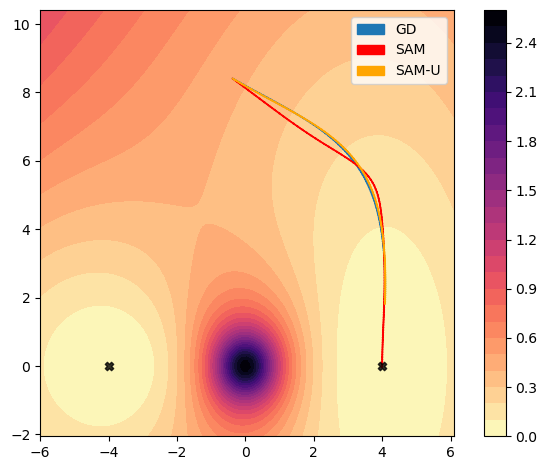

In [14]:
shared_idx = 0
gd_ex = gd_betas[shared_idx]
sam_ex = sam_betas[shared_idx]
samu_ex = samu_betas[shared_idx]

to_plot = [gd_ex.reshape(gd_ex.size // 2, 2),
           sam_ex.reshape(sam_ex.size // 2, 2),
           samu_ex.reshape(samu_ex.size // 2, 2),
           b1.reshape(1, 2), b2.reshape(1, 2)]

mM = plotting.get_mM_around_trajectory(np.concatenate(to_plot), padding=2)
print(mM)
fig, ax = plt.subplots(layout="tight")

cl = plotting.contour_loss(ax, loss_func, mM, contour_levels=30)
plotting.plot_arrows(ax, gd_ex[:, 0], gd_ex[:, -1], color=gd_color, label=gd_label)
plotting.plot_arrows(ax, sam_ex[:, 0], sam_ex[:, -1], color=sam_color, label=sam_label)
plotting.plot_arrows(ax, samu_ex[:, 0], samu_ex[:, -1], color=samu_color, label=samu_label)
plotting.plot_minimizer(ax, minimizer=b1)
plotting.plot_minimizer(ax, minimizer=b2)

fig.colorbar(cl)
# ax.set_xlabel("dimension 1")
# ax.Set_ylabel("dimension d")
ax.set_aspect("equal", "box")
ax.legend()

path = os.path.join(img_dir, f"non_convex_mixed_trajectories.pdf")
fig.savefig(path)

plt.show()